# LDA Topic Modeling

## Prerequisities

In [15]:
# Install nltk and spacy
!pip install nltk
!pip install spacy
!pip install gensim
!pip install pyLDAvis

# Download nltk stopwords
import nltk 
nltk.download('stopwords')

# Download spacy model
!python -m spacy download en

     |████████████████████████████████| 1.6 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 186 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 246 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 548 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 4.0 MB/s eta 0:00:01


  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=477d45aa04f636417def023eccedc6c938a235a2426919ac5bf1f74b3c2bd53f
  Stored in directory: /Users/hd33cc/Library/Caches/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=aa170c607fa22dd3e1bdf565231c94772d991b441734dcc4c383331a05b65e04
  Stored in directory: /Users/hd33cc/Library/Caches/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=16cacabbe09c0512ab3230d05e59b0533073d1e87f88b220707bb5eed48eca81
  Stored in directory: /Users/hd33cc/Library/Caches/pip/wheels/3c/33/97/805b282e129f60bb4e87cea622338f30b65f21eaf65219971f
Successfully built pyLDAvis future funcy


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hd33cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
//anaconda3/envs/ing/lib/python3.7/site-packages/en_core_web_sm -->
//anaconda3/envs/ing/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Import Packages

In [78]:
# General packages
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s: %(message)s', 
    level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Prepare Stopwords

In [79]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Import Newsgroup Dataset

In [82]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


## Clean Data

In [83]:
# Convert to list
data = df['content'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\''", "", sent) for sent in data]

print(data[:1])

["From: (where's my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- "]


## Word Tokenization and Text Clean-up

In [84]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(sent_to_words(data)) 

print(data_words[:1])

[['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Bigram and Triagram Models

In [85]:
# Build the bigram and trigram models. (higher treshold -> fewer phrases)
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Fastes way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See a trigram example
print('Trigram Example: \n', trigram_mod[bigram_mod[data_words[0]]])

Trigram Example: 
 ['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


## Remove Stopwords, Make Bigrams and Lemmatize

In [86]:
def remove_stopwords(texts):
    """ Function to remove stop words """
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    """ Function to form bigrams """
    return [bigram_mod[doc] for doc in texts]

def make_trigram(texts):
    """ Function to form trigrams """
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """ Function to lemmatize words keeping only allowed postags"""
    # Annotation reference in https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [87]:
# Remove Stop Words
data_words_nonstops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nonstops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


## Create Dictionary and Corpus for Topic Modeling

In [88]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequencyt
corpus  = [id2word.doc2bow(text) for text in texts]

# Print Example
print('Corpus 1: \n', corpus[0])
print(f"\nExample: \nWord -> \'%s\', Id -> %i, Frequency -> %i\n" % (id2word[0], corpus[0][0][0], corpus[0][0][1]))

Corpus 1: 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]

Example: 
Word -> 'addition', Id -> 0, Frequency -> 1



## Build the Topic Model

In [89]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=20,
                                     random_state=100,
                                     update_every=1,
                                     chunksize=100,
                                     passes=10,
                                     alpha='auto',
                                     per_word_topics=True)

## View the Topics in LDA Model

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

In [90]:
pprint(lda_model.print_topics())
doc_lda = lda_model

[(0,
  '0.039*"line" + 0.038*"write" + 0.030*"would" + 0.024*"article" + '
  '0.022*"know" + 0.021*"get" + 0.021*"go" + 0.017*"good" + 0.017*"time" + '
  '0.015*"see"'),
 (1,
  '0.223*"book" + 0.212*"faith" + 0.045*"scripture" + 0.021*"plain" + '
  '0.019*"birth" + 0.016*"era" + 0.015*"classic" + 0.011*"commandment" + '
  '0.010*"clh" + 0.009*"gentile"'),
 (2,
  '0.084*"greek" + 0.044*"cold" + 0.043*"usenet" + 0.042*"solid" + '
  '0.031*"bank" + 0.024*"powerful" + 0.024*"restore" + 0.022*"programmer" + '
  '0.020*"simm" + 0.019*"intelligence"'),
 (3,
  '0.054*"box" + 0.049*"switch" + 0.044*"master" + 0.042*"period" + '
  '0.036*"listen" + 0.031*"station" + 0.029*"air" + 0.028*"wave" + '
  '0.025*"decent" + 0.023*"prize"'),
 (4,
  '0.105*"team" + 0.097*"game" + 0.074*"play" + 0.069*"win" + 0.035*"season" + '
  '0.034*"year" + 0.032*"fan" + 0.030*"score" + 0.026*"wing" + 0.025*"goal"'),
 (5,
  '0.148*"key" + 0.048*"public" + 0.043*"government" + 0.042*"encryption" + '
  '0.039*"security"

## Compute Model Perplexity and Coherence Score

In [92]:
# Perplexity: a measure of how good the model is. The lower, the better
print('\nPerpelexity: ', lda_model.log_perplexity(corpus))

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perpelexity:  -12.946910866908558

Coherence Score:  0.4251916465215036


## Visualize the Topic's Keywords

In [93]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.331838  0.122410       1        1  32.362904
9     -0.328767  0.018882       2        1  17.947016
8     -0.275304 -0.023540       3        1  14.497325
7     -0.166134  0.177986       4        1   6.443629
10    -0.162238 -0.255149       5        1   5.070210
13    -0.113051 -0.089680       6        1   4.483492
12    -0.019703  0.133118       7        1   3.238954
19    -0.006655 -0.219766       8        1   2.956754
6      0.011982 -0.019700       9        1   2.612561
15     0.057374 -0.030978      10        1   1.692844
4      0.025201  0.147048      11        1   1.481251
5      0.036751 -0.103498      12        1   1.453571
14     0.118208  0.036875      13        1   1.167300
18     0.162354  0.018107      14        1   1.061820
17     0.125152  0.010038      15        1   1.052839
11     0.146584  0.034207      16        1   0.733575
3      0.164830  0.005414      17        1   0.666216
16     0.174604  0.010216      18        1   0.449612
1      0.178864  0.010569      19        1   0.366308
2      0.201787  0.017442      20        1   0.261814, topic_info=             Term          Freq         Total Category  logprob  loglift
191         write  13457.000000  13457.000000  Default  30.0000  30.0000
3666           ax   2732.000000   2732.000000  Default  29.0000  29.0000
19           line  15999.000000  15999.000000  Default  28.0000  28.0000
342         drive   3022.000000   3022.000000  Default  27.0000  27.0000
135        people   7726.000000   7726.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
11605  parliament      0.041092      1.258617  Topic20 -11.1635   2.5233
4467    interview      0.041092      1.258626  Topic20 -11.1635   2.5233
3622      discuss      0.041093      1.258688  Topic20 -11.1635   2.5233
3858     lebanese      0.041093      1.258720  Topic20 -11.1635   2.5233
3140       accord      0.041093      1.258722  Topic20 -11.1635   2.5233

[850 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2841     19  0.940287      abstract
80        3  0.998778        access
314      13  0.964527  accidentally
1276      8  0.994403       acquire
567       9  0.997419      activity
...     ...       ...           ...
392      13  0.989770        writer
39        1  0.115544          year
39        4  0.722637          year
39        6  0.042114          year
39       11  0.119216          year

[1059 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 9, 8, 11, 14, 13, 20, 7, 16, 5, 6, 15, 19, 18, 12, 4, 17, 2, 3])

## Building LDA Mallet Model

In [98]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('file', 0.04773030707610147),
   ('line', 0.026535380507343123),
   ('set', 0.019835971771886323),
   ('program', 0.019454510776273127),
   ('change', 0.018429334350562654),
   ('follow', 0.01776177760823956),
   ('read', 0.01432862864772077),
   ('write', 0.012063703986267405),
   ('entry', 0.011944497425138279),
   ('number', 0.01180144955178333)]),
 (13,
  [('line', 0.016416184971098265),
   ('work', 0.01582530507385999),
   ('power', 0.0148747591522158),
   ('current', 0.011663455362877329),
   ('ground', 0.01094412331406551),
   ('thing', 0.010044958253050738),
   ('high', 0.009274245343609506),
   ('wire', 0.009171483622350674),
   ('light', 0.008888888888888889),
   ('unit', 0.00819524727039178)]),
 (1,
  [('ax', 0.1859902423545278),
   ('line', 0.1614374677720043),
   ('max', 0.15076752211336322),
   ('host', 0.11510848439173377),
   ('nntp_poste', 0.043592082820990835),
   ('organization', 0.030185236603070088),
   ('reply', 0.02744833604379041),
   ('ca', 0.018721986

## Find Optimal Number of Topics for LDA

In [99]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [100]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

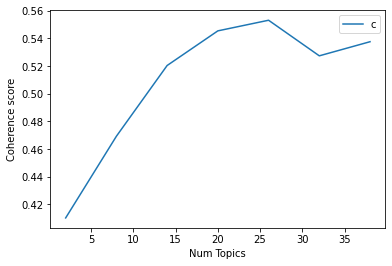

In [101]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [107]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4103
Num Topics = 8  has Coherence Value of 0.4692
Num Topics = 14  has Coherence Value of 0.5203
Num Topics = 20  has Coherence Value of 0.5453
Num Topics = 26  has Coherence Value of 0.553
Num Topics = 32  has Coherence Value of 0.5273
Num Topics = 38  has Coherence Value of 0.5375


In [108]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(17,
  '0.047*"question" + 0.035*"point" + 0.032*"give" + 0.027*"find" + '
  '0.025*"answer" + 0.023*"read" + 0.020*"time" + 0.019*"write" + 0.018*"word" '
  '+ 0.014*"post"'),
 (9,
  '0.050*"file" + 0.023*"line" + 0.023*"program" + 0.019*"number" + '
  '0.016*"follow" + 0.015*"entry" + 0.013*"section" + 0.012*"read" + '
  '0.012*"author" + 0.011*"include"'),
 (10,
  '0.043*"window" + 0.026*"file" + 0.025*"image" + 0.024*"program" + '
  '0.019*"display" + 0.018*"set" + 0.018*"run" + 0.017*"application" + '
  '0.016*"color" + 0.016*"server"'),
 (8,
  '0.301*"ax" + 0.244*"max" + 0.119*"line" + 0.015*"advance" + 0.008*"di_di" + '
  '0.006*"part" + 0.006*"end" + 0.004*"greatly_appreciate" + 0.004*"cut" + '
  '0.003*"greeting"'),
 (3,
  '0.026*"space" + 0.012*"launch" + 0.009*"year" + 0.009*"project" + '
  '0.008*"satellite" + 0.008*"system" + 0.008*"mission" + 0.008*"earth" + '
  '0.007*"technology" + 0.007*"design"'),
 (16,
  '0.015*"people" + 0.013*"israeli" + 0.011*"attack" + 0.011*"wa

## Find Dominant Topic In Each Sentence

In [109]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,24.0,0.1766,"car, bike, ride, drive, engine, turn, speed, f...",From: (where's my thing) Subject: WHAT car is ...
1,1,19.0,0.1037,"drive, card, problem, driver, system, bit, dis...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,11.0,0.1387,"good, time, thing, lot, bad, problem, back, lo...",From: (Thomas E Willis) Subject: PB questions....
3,3,5.0,0.1059,"write, article, line, opinion, organization, h...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,14.0,0.1186,"make, thing, idea, point, reason, difference, ...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,12.0,0.2811,"gun, weapon, crime, people, kill, drug, firear...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,23.0,0.0818,"study, food, doctor, patient, eat, test, effec...",From: (brian manning delaney) Subject: Brain T...
7,7,19.0,0.4943,"drive, card, problem, driver, system, bit, dis...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,10.0,0.1593,"window, file, image, program, display, set, ru...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,19.0,0.1651,"drive, card, problem, driver, system, bit, dis...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


## Find The Most Representative Document For Each Topic

In [110]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7041,"game, team, year, play, player, win, season, g...",From: (bryan.k.strouse) Subject: NHL RESULTS F...
1,1.0,0.5153,"people, make, man, life, person, moral, system...",From: (Dan S.) Subject: Re: New Study Out On G...
2,2.0,0.6181,"exist, true, evidence, claim, reason, argument...",From: (Robert Singleton) Subject: Re: American...
3,3.0,0.7294,"space, launch, year, project, satellite, syste...",From: (Jon Leech) Subject: Space FAQ 11/15 - U...
4,4.0,0.2118,"line, host, organization, write, reply, nntp_p...",From: (Ted Frank) Subject: Re: Gritz/JBS/Liber...


## Topic Distribution Accross Documents

In [111]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,24.0,"car, bike, ride, drive, engine, turn, speed, f...",1010.0,0.0893
1.0,19.0,"drive, card, problem, driver, system, bit, dis...",324.0,0.0286
2.0,11.0,"good, time, thing, lot, bad, problem, back, lo...",351.0,0.0310
3.0,5.0,"write, article, line, opinion, organization, h...",434.0,0.0384
4.0,14.0,"make, thing, idea, point, reason, difference, ...",641.0,0.0567
...,...,...,...,...
11309.0,23.0,"study, food, doctor, patient, eat, test, effec...",NaN,NaN
11310.0,19.0,"drive, card, problem, driver, system, bit, dis...",NaN,NaN
11311.0,19.0,"drive, card, problem, driver, system, bit, dis...",NaN,NaN
11312.0,17.0,"question, point, give, find, answer, read, tim...",NaN,NaN
